# Toxic comment classification 

## Importing the libraries and loading the data

In [79]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Model,Sequential
from keras.layers import Dense,Embedding, Input , Activation
from keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import initializers, optimizers, layers
from sklearn.metrics import  roc_auc_score
from sklearn.compose import make_column_transformer


In [86]:
#Loading the Train_test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [87]:
train.iloc[12]['comment_text']

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

In [19]:
total_rows = data.shape[0]
total_columns = data.shape[1]
data.isnull().sum()
print('Total number of rows : '+str(total_rows))
print('Total number of columns : '+str(total_columns))
print('Missing values in the Dataset :' +str(data.isnull().sum().sum()))

Total number of rows : 159571
Total number of columns : 8
Missing values in the Dataset :0


In [21]:
data['Clean'] =0 # creating the column
data.loc[(data['severe_toxic'] ==0 ) &(data['threat']==0) & (data['identity_hate']==0)
       & (data['insult']==0)& (data['obscene']==0) & (data['toxic']==0) ,
       'Clean'] = 1

Socket exception: An existing connection was forcibly closed by the remote host (10054)


In [24]:
# filtering the comment based on toxicity levels
clean_comment = " ".join(review for review in data[data['Clean']==1]['comment_text'])

negative_comment = " ".join(review for review in data[(data['severe_toxic'] ==1 ) | (data['threat']==1) |(data['identity_hate']==1)
       | (data['insult']==1)|(data['obscene']==1) | (data['toxic']==1)]['comment_text'])

severe_toxic_comment = " ".join(review for review in data[(data['severe_toxic'] ==1 )]['comment_text'])

threat_comment = " ".join(review for review in data[(data['threat']==1)]['comment_text'])

identity_hate_comment = " ".join(review for review in data[(data['identity_hate']==1)]['comment_text'])

insult_comment = " ".join(review for review in data[(data['insult']==1)]['comment_text'])

obscene_comment = " ".join(review for review in data[(data['obscene']==1)]['comment_text'])     

toxic_comment = " ".join(review for review in data[(data['toxic']==1)]['comment_text'])

In [26]:
df = data.iloc[ :,2:9]
corrMatrix=df.corr()
corrMatrix

,toxic,severe_toxic,obscene,threat,insult,identity_hate,Clean
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009,-0.967748
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600,-0.298666
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867,-0.702812
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128,-0.162925
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736,-0.677324
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000,-0.280144
Clean,-0.967748,-0.298666,-0.702812,-0.162925,-0.677324,-0.280144,1.000000


<AxesSubplot:>

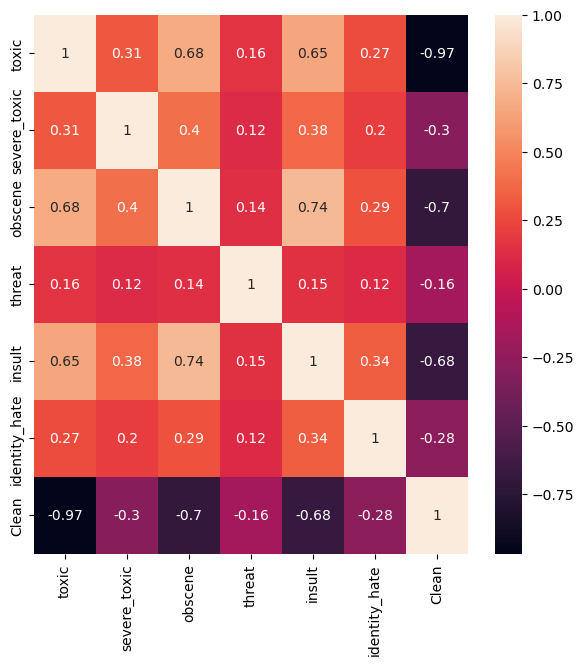

In [27]:
plt.figure(figsize=(7, 7))
sns.heatmap(corrMatrix, annot=True)

In [28]:
#----------------------------------------------------------------------------------------------------------
#MODELLING
#-------------------------------------------------------------------------------------------------------------
toxic_data = pd.read_csv("train.csv")
toxic_data.head()
toxic_data['word_count'] = toxic_data['comment_text'].apply(lambda x: len(str(x).split(" ")))
toxic_data.iloc[:,2:].head(10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,word_count
0,0,0,0,0,0,0,42
1,0,0,0,0,0,0,18
2,0,0,0,0,0,0,42
3,0,0,0,0,0,0,112
4,0,0,0,0,0,0,13
5,0,0,0,0,0,0,12
6,1,1,1,0,1,0,8
7,0,0,0,0,0,0,21
8,0,0,0,0,0,0,83
9,0,0,0,0,0,0,12


In [30]:
#-------------------------------------------
#------TEXT MINING ------------------------
#------------------------------------------
#converting the text to lowercase
toxic_data['clean_comments'] = toxic_data['comment_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#removing punctuation
toxic_data['clean_comments'] = toxic_data['clean_comments'].str.replace('[^\w\s]','')

# removing the stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
toxic_data['clean_comments'] = toxic_data['clean_comments'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))



C:\Users\pares\AppData\Local\Temp\ipykernel_16248\3439322775.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  toxic_data['clean_comments'] = toxic_data['clean_comments'].str.replace('[^\w\s]','')


In [33]:
# performing lemmatization
#nltk.download('wordnet')
# !pip install textblob
from textblob import Word
toxic_data['clean_comments'] = toxic_data['clean_comments'].apply(lambda x: " ".join([Word(i).lemmatize() for i in x.split()]))
toxic_data['clean_comments'].head()

0    explanation edits made username hardcore metal...
1    daww match background colour im seemingly stuc...
2    hey man im really trying edit war guy constant...
3    cant make real suggestion improvement wondered...
4                  sir hero chance remember page thats
Name: clean_comments, dtype: object

In [34]:
#---------------------------------------------------
#------FEATURE EXTRACTION : BOW---------------------
#---------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
tokenCV = RegexpTokenizer(r'[a-zA-Z0-9]+')
comment_count = CountVectorizer(lowercase=True, ngram_range=(1,1),analyzer = "word",tokenizer = tokenCV.tokenize)
comment_count.fit(toxic_data['clean_comments'])
# print(comment_counttt.vocabulary_)
comment_count=comment_count.transform(toxic_data['clean_comments'])
comment_count

C:\Users\pares\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<159571x237932 sparse matrix of type '<class 'numpy.int64'>'
	with 4435344 stored elements in Compressed Sparse Row format>

In [35]:
from nltk.stem.wordnet import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lem = WordNetLemmatizer()
tokenCV = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = tokenCV.tokenize)

In [37]:
import re
import string
w, h = 1,len(toxic_data);
comments_clean = [[0 for x in range(w)] for y in range(h)] 

w, h = 2,len(toxic_data);
comments_sa = [[0 for x in range(w)] for y in range(h)] 

for i in range(0,len(toxic_data)):
	comments = toxic_data.iloc[i,1]
	comments = comments.lower()
	comments = re.sub(r'\d+', '', comments)
	comments = comments.translate(str.maketrans("","", string.punctuation))
	comments = comments.strip()
	comments = lem.lemmatize(comments)
	tokens = word_tokenize(comments)
	comments = [j for j in tokens if not j in stop_words]
	comments_clean[i] = str(comments)
	
text_counts= cv.fit_transform(comments_clean)


In [88]:
#Listing down the Classes
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

y = train[list_classes].values

In [89]:
#Train and test labels
list_sequences_train = train["comment_text"]
list_sequences_test = test["comment_text"]

max_features = 22000
tokenizer = Tokenizer(num_words=max_features)
train = tokenizer.fit_on_texts(list(list_sequences_train))


In [90]:
#Tokenizing and Indexing the comments
list_tokenized_train = tokenizer.texts_to_sequences(list_sequences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sequences_test)

#Defining the train and test sequences
#200 is the maximum length of the inut stream. Samll sentence =0, long sentences will be trimmed
maxlen = 200
X_train = pad_sequences(list_tokenized_train, maxlen = maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen = maxlen)

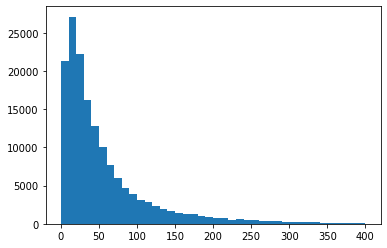

In [91]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

#Visualizing the Distribution of the words
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()


# Lets create the cnn and rnn models and check their validation and training accuries

In [92]:
#Step1: Adding the first Input Layer (None,200)
inp = Input(shape=(maxlen, ))

In [105]:
#Step2: Adding the embedding Layer (None,200,128)
#128 is a tunable params(Creating Word Embeddings)
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

#Step3: Defining the LSTM Layer with 60 Output
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)

#Step4: Global Max Pooling Layer to convert 3D tensor into 2D
x = GlobalMaxPooling1D()(x)

#Step5: Adding a Dropout Reguralisation
x = Dropout(0.1)(x)

#Step6: Adding a Dense Layer
x = Dense(50, activation = 'relu')(x)

x = Dropout(0.1)(x)

#Step7: Final Output Layer
x = Dense(6, activation="sigmoid")(x)


model1=Model(inputs=inp, outputs = x)

model1.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

batch_size = 32
epochs = 10

In [106]:
model1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 200, 128)          2816000   
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           45360     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 60)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_8 (Dropout)         (None, 60)                0         
                                                                 
 dense_22 (Dense)            (None, 50)                3050      
                                                           

In [107]:
history1 = model1.fit(X_train, y, batch_size = batch_size, epochs = 7, validation_split=0.1,verbose=2)

Epoch 1/7
4488/4488 - 52s - loss: 0.0672 - accuracy: 0.9599 - val_loss: 0.0490 - val_accuracy: 0.9940 - 52s/epoch - 12ms/step
Epoch 2/7
4488/4488 - 49s - loss: 0.0456 - accuracy: 0.9922 - val_loss: 0.0475 - val_accuracy: 0.9933 - 49s/epoch - 11ms/step
Epoch 3/7
4488/4488 - 48s - loss: 0.0402 - accuracy: 0.9865 - val_loss: 0.0474 - val_accuracy: 0.9931 - 48s/epoch - 11ms/step
Epoch 4/7
4488/4488 - 49s - loss: 0.0353 - accuracy: 0.9570 - val_loss: 0.0490 - val_accuracy: 0.9932 - 49s/epoch - 11ms/step
Epoch 5/7
4488/4488 - 53s - loss: 0.0309 - accuracy: 0.8723 - val_loss: 0.0524 - val_accuracy: 0.9737 - 53s/epoch - 12ms/step
Epoch 6/7
4488/4488 - 58s - loss: 0.0273 - accuracy: 0.8051 - val_loss: 0.0545 - val_accuracy: 0.8904 - 58s/epoch - 13ms/step
Epoch 7/7
4488/4488 - 48s - loss: 0.0238 - accuracy: 0.6700 - val_loss: 0.0626 - val_accuracy: 0.5033 - 48s/epoch - 11ms/step


In [108]:
history1.history

{'loss': [0.06724943965673447,
  0.045592132955789566,
  0.040171679109334946,
  0.03534392639994621,
  0.030895035713911057,
  0.027294564992189407,
  0.023832356557250023],
 'accuracy': [0.9598782658576965,
  0.9922012686729431,
  0.9865332245826721,
  0.9569815993309021,
  0.872344434261322,
  0.8050733804702759,
  0.6699532866477966],
 'val_loss': [0.049017347395420074,
  0.047517385333776474,
  0.04735197871923447,
  0.04902855306863785,
  0.0523986853659153,
  0.05448704585433006,
  0.06257153302431107],
 'val_accuracy': [0.9939842224121094,
  0.993294894695282,
  0.9931069016456604,
  0.9931695461273193,
  0.9737435579299927,
  0.8903998136520386,
  0.5033212304115295]}

<Figure size 576x360 with 0 Axes>

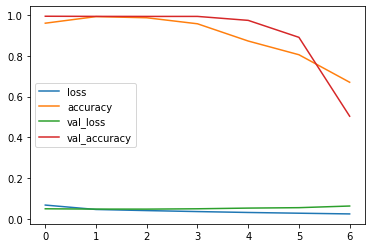

In [109]:
plt.figure(figsize=(8,5))
pd.DataFrame(history1.history).plot()
plt.show()

In [100]:
#Step2: Adding the embedding Layer (None,200,128)
#128 is a tunable params(Creating Word Embeddings)
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

#Step3: Defining the LSTM Layer with 60 Output
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)

#Step4: Global Max Pooling Layer to convert 3D tensor into 2D
x = GlobalMaxPooling1D()(x)

#Step5: Adding a Dropout Reguralisation
x = Dropout(0.2)(x)



#Step6: Adding a Dense Layer
x = Dense(128,activation = 'relu') (x)
x = Dense(256,activation = 'relu') (x)
x = Dense(128,activation = 'relu') (x)

x = Dropout(0.1)(x)

#Step7: Final Output Layer
x = Dense(6, activation="sigmoid")(x)


model2=Model(inputs=inp, outputs = x)

model2.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

batch_size = 32
epochs = 10

In [101]:
history2 = model2.fit(X_train, y, batch_size = batch_size, epochs = epochs, validation_split=0.1)


Epoch 1/10
4488/4488 [==============================] - 63s 14ms/step - loss: 0.0623 - accuracy: 0.9612 - val_loss: 0.0497 - val_accuracy: 0.9939
Epoch 2/10
4488/4488 [==============================] - 54s 12ms/step - loss: 0.0448 - accuracy: 0.9916 - val_loss: 0.0482 - val_accuracy: 0.9940
Epoch 3/10
4488/4488 [==============================] - 55s 12ms/step - loss: 0.0388 - accuracy: 0.9918 - val_loss: 0.0479 - val_accuracy: 0.9940
Epoch 4/10
4488/4488 [==============================] - 55s 12ms/step - loss: 0.0344 - accuracy: 0.9891 - val_loss: 0.0509 - val_accuracy: 0.9940
Epoch 5/10
4488/4488 [==============================] - 54s 12ms/step - loss: 0.0306 - accuracy: 0.9874 - val_loss: 0.0529 - val_accuracy: 0.9940
Epoch 6/10
4488/4488 [==============================] - 55s 12ms/step - loss: 0.0276 - accuracy: 0.9542 - val_loss: 0.0573 - val_accuracy: 0.9924
Epoch 7/10
4488/4488 [==============================] - 54s 12ms/step - loss: 0.0250 - accuracy: 0.9544 - val_loss: 0.0640 -

<Figure size 576x360 with 0 Axes>

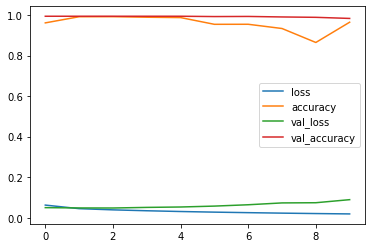

In [102]:
plt.figure(figsize=(8,5))
pd.DataFrame(history2.history).plot()
plt.show()

In [129]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D

model3 = Sequential()
model3.add(Embedding(max_features, embed_size))
model3.add(Dropout(0.2))


model3.add(Conv1D(150, 3, activation = 'relu'))
model3.add(MaxPooling1D())
model3.add(Conv1D(150, 3, activation = 'relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(150, activation = 'relu'))
model3.add(Dense(300, activation = 'relu'))
model3.add(Dense(150, activation = 'relu'))
model3.add(Dropout(0.2))

model3.add(Dense(6, activation = 'sigmoid'))

# Display the model structure
model3.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])
model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 128)         2816000   
                                                                 
 dropout_14 (Dropout)        (None, None, 128)         0         
                                                                 
 conv1d_6 (Conv1D)           (None, None, 150)         57750     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 150)        0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, None, 150)         67650     
                                                                 
 global_max_pooling1d_7 (Glo  (None, 150)              0         
 balMaxPooling1D)                                     

In [130]:
history3 = model3.fit(X_train, y, batch_size = 32, epochs = 10, validation_split=0.1)


Epoch 1/10
4488/4488 [==============================] - 34s 7ms/step - loss: 0.0634 - accuracy: 0.9646 - val_loss: 0.0537 - val_accuracy: 0.9940
Epoch 2/10
4488/4488 [==============================] - 32s 7ms/step - loss: 0.0465 - accuracy: 0.9936 - val_loss: 0.0522 - val_accuracy: 0.9940
Epoch 3/10
4488/4488 [==============================] - 31s 7ms/step - loss: 0.0406 - accuracy: 0.9899 - val_loss: 0.0522 - val_accuracy: 0.9939
Epoch 4/10
4488/4488 [==============================] - 31s 7ms/step - loss: 0.0358 - accuracy: 0.9933 - val_loss: 0.0554 - val_accuracy: 0.9940
Epoch 5/10
4488/4488 [==============================] - 31s 7ms/step - loss: 0.0320 - accuracy: 0.9923 - val_loss: 0.0685 - val_accuracy: 0.9927
Epoch 6/10
4488/4488 [==============================] - 31s 7ms/step - loss: 0.0291 - accuracy: 0.9883 - val_loss: 0.0743 - val_accuracy: 0.9939
Epoch 7/10
4488/4488 [==============================] - 31s 7ms/step - loss: 0.0272 - accuracy: 0.9865 - val_loss: 0.0607 - val_ac

<Figure size 576x360 with 0 Axes>

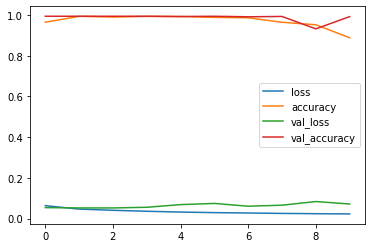

In [132]:
plt.figure(figsize=(8,5))
pd.DataFrame(history3.history).plot()
plt.show()

# Lets create the same models but applying the early stopping because we can see that we are getting better accuries with these models itself only problem is the accuracy is getting dipped down and grow after while which is the signal of the overfitting of the model

In [135]:
from keras.callbacks import EarlyStopping , ModelCheckpoint


In [136]:
, ModelCheckpoint
#Step2: Adding the embedding Layer (None,200,128)
#128 is a tunable params(Creating Word Embeddings)
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

#Step3: Defining the LSTM Layer with 60 Output
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)

#Step4: Global Max Pooling Layer to convert 3D tensor into 2D
x = GlobalMaxPooling1D()(x)

#Step5: Adding a Dropout Reguralisation
x = Dropout(0.2)(x)



#Step6: Adding a Dense Layer
x = Dense(128,activation = 'relu') (x)
x = Dense(256,activation = 'relu') (x)
x = Dense(128,activation = 'relu') (x)

x = Dropout(0.1)(x)

#Step7: Final Output Layer
x = Dense(6, activation="sigmoid")(x)


model2=Model(inputs=inp, outputs = x)

model2.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

es = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    verbose = 1,
    mode = min
)

mc = ModelCheckpoint(
    'lstm_model1.h5',
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True
)


batch_size = 32
epochs = 10

history2 = model2.fit(X_train, y, batch_size = batch_size, epochs = epochs, validation_split=0.1,callbacks = [es,mc],verbose=1)


Epoch 1/10
4484/4488 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9580
Epoch 1: val_accuracy improved from -inf to 0.29929, saving model to lstm_model1.h5
4488/4488 [==============================] - 55s 12ms/step - loss: 0.0174 - accuracy: 0.9575 - val_loss: 0.0801 - val_accuracy: 0.2993
Epoch 2/10
4487/4488 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.8032
Epoch 2: val_accuracy improved from 0.29929 to 0.97500, saving model to lstm_model1.h5
4488/4488 [==============================] - 56s 12ms/step - loss: 0.0160 - accuracy: 0.8033 - val_loss: 0.0844 - val_accuracy: 0.9750
Epoch 3/10
4486/4488 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9021
Epoch 3: val_accuracy improved from 0.97500 to 0.98352, saving model to lstm_model1.h5
4488/4488 [==============================] - 55s 12ms/step - loss: 0.0148 - accuracy: 0.9022 - val_loss: 0.0960 - val_accuracy: 0.9835
Epoch 4/10
4486/4488 [=====================

<Figure size 576x360 with 0 Axes>

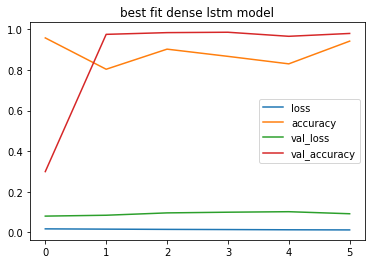

In [144]:
plt.figure(figsize=(8,5))
pd.DataFrame(history2.history).plot()
plt.title("best fit dense lstm model")
plt.show()

In [140]:

#Step2: Adding the embedding Layer (None,200,128)
#128 is a tunable params(Creating Word Embeddings)

embed_size = 128
x = Embedding(max_features, embed_size)(inp)

#Step3: Defining the LSTM Layer with 60 Output
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)

#Step4: Global Max Pooling Layer to convert 3D tensor into 2D
x = GlobalMaxPooling1D()(x)

#Step5: Adding a Dropout Reguralisation
x = Dropout(0.1)(x)

#Step6: Adding a Dense Layer
x = Dense(50, activation = 'relu')(x)

x = Dropout(0.1)(x)

#Step7: Final Output Layer
x = Dense(6, activation="sigmoid")(x)


model1=Model(inputs=inp, outputs = x)

model1.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])


es = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    verbose = 1,
    mode = min
)

mc = ModelCheckpoint(
    'lstm_model2.h5',
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True
)


batch_size = 32
epochs = 10

history1 = model1.fit(X_train, y, batch_size = batch_size, epochs = epochs, validation_split=0.1,callbacks = [es,mc],verbose=1)


Epoch 1/10
4485/4488 [============================>.] - ETA: 0s - loss: 0.0703 - accuracy: 0.9404
Epoch 1: val_accuracy improved from -inf to 0.99398, saving model to lstm_model2.h5
4488/4488 [==============================] - 82s 13ms/step - loss: 0.0703 - accuracy: 0.9404 - val_loss: 0.0496 - val_accuracy: 0.9940
Epoch 2/10
4484/4488 [============================>.] - ETA: 0s - loss: 0.0446 - accuracy: 0.9846
Epoch 2: val_accuracy did not improve from 0.99398
4488/4488 [==============================] - 55s 12ms/step - loss: 0.0446 - accuracy: 0.9846 - val_loss: 0.0466 - val_accuracy: 0.9940
Epoch 3/10
4486/4488 [============================>.] - ETA: 0s - loss: 0.0389 - accuracy: 0.9728
Epoch 3: val_accuracy did not improve from 0.99398
4488/4488 [==============================] - 54s 12ms/step - loss: 0.0389 - accuracy: 0.9728 - val_loss: 0.0472 - val_accuracy: 0.9926
Epoch 4/10
4484/4488 [============================>.] - ETA: 0s - loss: 0.0341 - accuracy: 0.9213
Epoch 4: val_accu

In [141]:
model3 = Sequential()
model3.add(Embedding(max_features, embed_size))
model3.add(Dropout(0.2))


model3.add(Conv1D(150, 3, activation = 'relu'))
model3.add(MaxPooling1D())
model3.add(Conv1D(150, 3, activation = 'relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(150, activation = 'relu'))
model3.add(Dense(300, activation = 'relu'))
model3.add(Dense(150, activation = 'relu'))
model3.add(Dropout(0.2))

model3.add(Dense(6, activation = 'sigmoid'))

# Display the model structure
model3.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])
es = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    verbose = 1,
    mode = min
)

mc = ModelCheckpoint(
    'cnn_model.h5',
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True
)


batch_size = 32
epochs = 10

history3 = model3.fit(X_train, y, batch_size = batch_size, epochs = epochs, validation_split=0.1,callbacks = [es,mc],verbose=1)


Epoch 1/10
4481/4488 [============================>.] - ETA: 0s - loss: 0.0636 - accuracy: 0.9644
Epoch 1: val_accuracy improved from -inf to 0.99398, saving model to cnn_model.h5
4488/4488 [==============================] - 32s 7ms/step - loss: 0.0636 - accuracy: 0.9644 - val_loss: 0.0515 - val_accuracy: 0.9940
Epoch 2/10
4488/4488 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9922
Epoch 2: val_accuracy did not improve from 0.99398
4488/4488 [==============================] - 31s 7ms/step - loss: 0.0464 - accuracy: 0.9922 - val_loss: 0.0504 - val_accuracy: 0.9940
Epoch 3/10
4485/4488 [============================>.] - ETA: 0s - loss: 0.0405 - accuracy: 0.9858
Epoch 3: val_accuracy did not improve from 0.99398
4488/4488 [==============================] - 30s 7ms/step - loss: 0.0405 - accuracy: 0.9858 - val_loss: 0.0518 - val_accuracy: 0.9934
Epoch 4/10
4484/4488 [============================>.] - ETA: 0s - loss: 0.0357 - accuracy: 0.9913
Epoch 4: val_accuracy 

<Figure size 576x360 with 0 Axes>

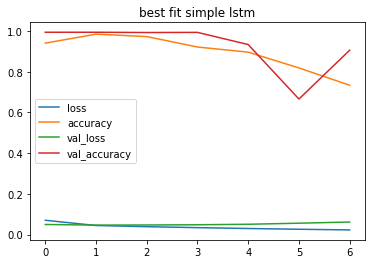

In [142]:
plt.figure(figsize=(8,5))
pd.DataFrame(history1.history).plot()
plt.title("best fit simple lstm")
plt.show()

<Figure size 576x360 with 0 Axes>

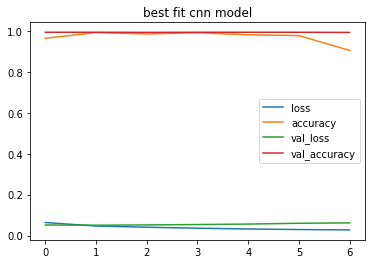

In [143]:
plt.figure(figsize=(8,5))
pd.DataFrame(history3.history).plot()
plt.title("best fit cnn model")
plt.show()

## using machine learning algorithms

In [17]:
# Loading Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
import os
import nltk.corpus
from nltk.tokenize import word_tokenize
#loading dataset
data = pd.read_csv("train.csv")
data.head(4)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0


In [48]:
# creating matrix to store predcicted values
l, b = len(y_train), 6;
Pred_Matrix_train = [[0 for x in range(l)] for y in range(b)] 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix


In [44]:
#-------------------------------
#---Logistic
from sklearn.linear_model import LogisticRegression
#defining logistic regression function
def logreg(train_x,train_y,test_x):
    logreg = LogisticRegression(solver='sag')
    logreg.fit(X_train, y_train.iloc[:,i])
    y_pred = logreg.predict(X_test)
    return y_pred
for i in range(0, 6):
    Pred_Matrix_train[i] = logreg(X_train, y_train.iloc[:,i],X_test)
pred_lr = pd.DataFrame(data=Pred_Matrix_train)
pred_lr_val =pred_lr.T


C:\Users\pares\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\pares\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\pares\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\pares\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\pares\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\pares\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

NameError: name 'metrics' is not defined

In [46]:
print('Accuracy of the Logistic Regression model : '+str(accuracy_score(y_test, pred_lr_val)))
print('Classification Report for Logistic Regression : ')
print(classification_report(y_test, pred_lr_val))

Accuracy of the Logistic Regression model : 0.9030549898167006
Classification Report for Logistic Regression : 
              precision    recall  f1-score   support

           0       0.97      0.23      0.38      3103
           1       0.47      0.17      0.25       303
           2       0.97      0.26      0.41      1687
           3       0.00      0.00      0.00       101
           4       0.82      0.19      0.30      1574
           5       0.60      0.01      0.02       286

   micro avg       0.90      0.21      0.35      7054
   macro avg       0.64      0.14      0.23      7054
weighted avg       0.88      0.21      0.34      7054
 samples avg       0.02      0.02      0.02      7054



C:\Users\pares\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pares\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
#---------Naive Baye's------
from sklearn.naive_bayes import MultinomialNB
for i in range(0,6):
    mnb_model = MultinomialNB().fit(X_train, y_train.iloc[:,i])
#     Pred_Matrix[i]= mnb_model.predict_proba(x_test)[:,1]
    Pred_Matrix_train[i]= mnb_model.predict(X_test)
pred_mnb = pd.DataFrame(data=Pred_Matrix_train)
pred_mnb_val =pred_mnb.T
print('Accuracy of the Naive Bayes  model : '+str(accuracy_score(y_test, pred_mnb_val)))
print('Classification Report for Naive Bayes : ')
print(classification_report(y_test, pred_mnb_val))

Accuracy of the Naive Bayes  model : 0.8963496788344039
Classification Report for Naive Bayes : 
              precision    recall  f1-score   support

           0       0.73      0.59      0.66      3103
           1       0.31      0.42      0.36       303
           2       0.65      0.59      0.62      1687
           3       0.05      0.04      0.04       101
           4       0.59      0.51      0.55      1574
           5       0.21      0.15      0.18       286

   micro avg       0.62      0.54      0.58      7054
   macro avg       0.42      0.39      0.40      7054
weighted avg       0.63      0.54      0.58      7054
 samples avg       0.05      0.05      0.05      7054



C:\Users\pares\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pares\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
